# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_94585/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_94585/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_94585/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 5.0 },  #E[λ_T] = 0.40  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": 1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 30.0 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 15.0 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4465  val=235.6697  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510


  0%|          | 2/1000 [00:01<09:37,  1.73it/s]

[2/1000] train=232.9713  val=232.7374  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520


  0%|          | 3/1000 [00:01<10:06,  1.64it/s]

[3/1000] train=227.0025  val=229.8072  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 4/1000 [00:02<11:30,  1.44it/s]

[4/1000] train=222.9251  val=226.8795  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541


  0%|          | 5/1000 [00:03<12:09,  1.36it/s]

[5/1000] train=222.9424  val=223.9534  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551


  1%|          | 6/1000 [00:04<12:49,  1.29it/s]

[6/1000] train=223.6591  val=221.0292  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 7/1000 [00:04<12:27,  1.33it/s]

[7/1000] train=217.1123  val=218.1069  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573


  1%|          | 8/1000 [00:06<16:07,  1.03it/s]

[8/1000] train=217.2511  val=215.1867  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584


  1%|          | 9/1000 [00:07<16:45,  1.01s/it]

[9/1000] train=214.0172  val=212.2685  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|          | 10/1000 [00:08<16:20,  1.01it/s]

[10/1000] train=207.2079  val=209.3524  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607


  1%|          | 11/1000 [00:09<15:42,  1.05it/s]

[11/1000] train=211.5533  val=206.4380  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619


  1%|          | 12/1000 [00:10<14:40,  1.12it/s]

[12/1000] train=207.8158  val=203.5256  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  1%|▏         | 13/1000 [00:10<14:38,  1.12it/s]

[13/1000] train=203.8202  val=200.6150  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644


  1%|▏         | 14/1000 [00:11<14:12,  1.16it/s]

[14/1000] train=207.6749  val=197.7069  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656


  2%|▏         | 15/1000 [00:12<15:27,  1.06it/s]

[15/1000] train=196.3282  val=194.8005  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 16/1000 [00:14<16:15,  1.01it/s]

[16/1000] train=193.9002  val=191.8956  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682


  2%|▏         | 17/1000 [00:15<16:12,  1.01it/s]

[17/1000] train=194.0150  val=188.9926  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696


  2%|▏         | 18/1000 [00:16<16:53,  1.03s/it]

[18/1000] train=185.4892  val=186.0919  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▏         | 19/1000 [00:17<16:14,  1.01it/s]

[19/1000] train=183.1237  val=183.1935  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723


  2%|▏         | 20/1000 [00:17<15:44,  1.04it/s]

[20/1000] train=183.0106  val=180.2977  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737


  2%|▏         | 21/1000 [00:19<16:22,  1.00s/it]

[21/1000] train=180.2794  val=177.4042  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  2%|▏         | 22/1000 [00:20<16:48,  1.03s/it]

[22/1000] train=177.9341  val=174.5129  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766


  2%|▏         | 23/1000 [00:21<17:26,  1.07s/it]

[23/1000] train=173.5332  val=171.6236  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781


  2%|▏         | 24/1000 [00:22<17:59,  1.11s/it]

[24/1000] train=168.4718  val=168.7370  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  2%|▎         | 25/1000 [00:23<18:41,  1.15s/it]

[25/1000] train=168.9172  val=165.8530  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0812


  3%|▎         | 26/1000 [00:24<17:48,  1.10s/it]

[26/1000] train=163.9110  val=162.9715  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827


  3%|▎         | 27/1000 [00:26<19:35,  1.21s/it]

[27/1000] train=161.7967  val=160.0922  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  3%|▎         | 28/1000 [00:27<19:17,  1.19s/it]

[28/1000] train=159.4375  val=157.2153  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0859  σmax=0.0860


  3%|▎         | 29/1000 [00:28<19:39,  1.21s/it]

[29/1000] train=153.3445  val=154.3403  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876


  3%|▎         | 30/1000 [00:29<18:58,  1.17s/it]

[30/1000] train=155.0695  val=151.4674  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  3%|▎         | 31/1000 [00:31<24:06,  1.49s/it]

[31/1000] train=150.5629  val=148.5970  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910


  3%|▎         | 32/1000 [00:34<30:16,  1.88s/it]

[32/1000] train=150.1311  val=145.7293  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928


  3%|▎         | 33/1000 [00:37<34:11,  2.12s/it]

[33/1000] train=145.4295  val=142.8647  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  3%|▎         | 34/1000 [00:39<33:38,  2.09s/it]

[34/1000] train=142.5853  val=140.0030  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax=0.0964


  4%|▎         | 35/1000 [00:41<34:25,  2.14s/it]

[35/1000] train=137.7781  val=137.1439  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0983  σmin=0.0982  σmax=0.0983


  4%|▎         | 36/1000 [00:44<35:49,  2.23s/it]

[36/1000] train=138.8780  val=134.2872  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  4%|▎         | 37/1000 [00:45<34:10,  2.13s/it]

[37/1000] train=134.1596  val=131.4332  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1021  σmin=0.1020  σmax=0.1021


  4%|▍         | 38/1000 [00:47<32:57,  2.06s/it]

[38/1000] train=130.1982  val=128.5822  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040


  4%|▍         | 39/1000 [00:49<31:43,  1.98s/it]

[39/1000] train=128.7517  val=125.7341  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  4%|▍         | 40/1000 [00:51<31:19,  1.96s/it]

[40/1000] train=125.0410  val=122.8893  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1081  σmin=0.1080  σmax=0.1081


  4%|▍         | 41/1000 [00:53<30:32,  1.91s/it]

[41/1000] train=123.4928  val=120.0481  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1101  σmax=0.1101


  4%|▍         | 42/1000 [00:55<30:19,  1.90s/it]

[42/1000] train=119.2624  val=117.2100  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1122  σmax=0.1122


  4%|▍         | 43/1000 [00:57<29:45,  1.87s/it]

[43/1000] train=116.8095  val=114.3746  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1144  σmin=0.1143  σmax=0.1144


  4%|▍         | 44/1000 [00:59<30:40,  1.93s/it]

[44/1000] train=113.0539  val=111.5420  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1165  σmax=0.1166


  4%|▍         | 45/1000 [01:01<34:01,  2.14s/it]

[45/1000] train=110.9415  val=108.7113  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  5%|▍         | 46/1000 [01:03<34:25,  2.17s/it]

[46/1000] train=109.4723  val=105.8831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1210  σmin=0.1209  σmax=0.1210


  5%|▍         | 47/1000 [01:05<33:10,  2.09s/it]

[47/1000] train=104.8838  val=103.0584  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1233  σmin=0.1232  σmax=0.1233


  5%|▍         | 48/1000 [01:07<32:40,  2.06s/it]

[48/1000] train=103.2216  val=100.2379  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1257  σmin=0.1256  σmax=0.1257


  5%|▍         | 49/1000 [01:09<32:54,  2.08s/it]

[49/1000] train=100.8209  val=97.4212  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1281  σmin=0.1279  σmax=0.1281


  5%|▌         | 50/1000 [01:12<33:03,  2.09s/it]

[50/1000] train=96.9615  val=94.6082  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1305  σmin=0.1303  σmax=0.1305


  5%|▌         | 51/1000 [01:15<37:08,  2.35s/it]

[51/1000] train=95.0172  val=91.7986  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  5%|▌         | 52/1000 [01:18<41:25,  2.62s/it]

[52/1000] train=90.7315  val=88.9925  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1355  σmin=0.1353  σmax=0.1355


  5%|▌         | 53/1000 [01:20<38:43,  2.45s/it]

[53/1000] train=89.4005  val=86.1901  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1380  σmin=0.1378  σmax=0.1380


  5%|▌         | 54/1000 [01:22<37:56,  2.41s/it]

[54/1000] train=86.0254  val=83.3913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  6%|▌         | 55/1000 [01:24<37:17,  2.37s/it]

[55/1000] train=82.9034  val=80.5965  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1433  σmin=0.1431  σmax=0.1433


  6%|▌         | 56/1000 [01:28<43:15,  2.75s/it]

[56/1000] train=78.6551  val=77.8054  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1460  σmin=0.1457  σmax=0.1460


  6%|▌         | 57/1000 [01:30<41:00,  2.61s/it]

[57/1000] train=75.1441  val=75.0181  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1487  σmin=0.1485  σmax=0.1487


  6%|▌         | 58/1000 [01:33<38:55,  2.48s/it]

[58/1000] train=75.1467  val=72.2346  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1515  σmin=0.1512  σmax=0.1515


  6%|▌         | 59/1000 [01:35<41:01,  2.62s/it]

[59/1000] train=70.8358  val=69.4542  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1543  σmin=0.1541  σmax=0.1543


  6%|▌         | 60/1000 [01:38<39:11,  2.50s/it]

[60/1000] train=69.2514  val=66.6777  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1572  σmin=0.1569  σmax=0.1572


  6%|▌         | 61/1000 [01:40<36:54,  2.36s/it]

[61/1000] train=63.3878  val=63.9061  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1601  σmin=0.1598  σmax=0.1602


  6%|▌         | 62/1000 [01:42<34:09,  2.19s/it]

[62/1000] train=62.3117  val=61.1394  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1631  σmin=0.1628  σmax=0.1631


  6%|▋         | 63/1000 [01:43<32:27,  2.08s/it]

[63/1000] train=59.8070  val=58.3777  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1658  σmax=0.1662


  6%|▋         | 64/1000 [01:45<31:17,  2.01s/it]

[64/1000] train=57.9375  val=55.6198  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693


  6%|▋         | 65/1000 [01:47<30:32,  1.96s/it]

[65/1000] train=55.6154  val=52.8649  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1724  σmin=0.1720  σmax=0.1724


  7%|▋         | 66/1000 [01:49<29:55,  1.92s/it]

[66/1000] train=52.5060  val=50.1133  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  7%|▋         | 67/1000 [01:51<28:50,  1.85s/it]

[67/1000] train=49.8867  val=47.3672  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1788  σmin=0.1784  σmax=0.1789


  7%|▋         | 68/1000 [01:53<30:04,  1.94s/it]

[68/1000] train=48.0976  val=44.6255  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1821  σmin=0.1816  σmax=0.1822


  7%|▋         | 69/1000 [01:55<30:26,  1.96s/it]

[69/1000] train=42.9292  val=41.8884  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1855  σmin=0.1849  σmax=0.1855


  7%|▋         | 70/1000 [01:56<29:14,  1.89s/it]

[70/1000] train=40.4495  val=39.1559  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1889  σmin=0.1883  σmax=0.1889


  7%|▋         | 71/1000 [01:58<28:29,  1.84s/it]

[71/1000] train=37.5225  val=36.4282  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1924  σmin=0.1917  σmax=0.1924


  7%|▋         | 72/1000 [02:00<28:04,  1.81s/it]

[72/1000] train=37.2860  val=33.7058  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1959  σmin=0.1952  σmax=0.1959


  7%|▋         | 73/1000 [02:02<27:40,  1.79s/it]

[73/1000] train=32.8708  val=30.9901  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1995  σmin=0.1987  σmax=0.1995


  7%|▋         | 74/1000 [02:03<27:21,  1.77s/it]

[74/1000] train=30.8007  val=28.2808  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2031  σmin=0.2023  σmax=0.2032


  8%|▊         | 75/1000 [02:05<27:08,  1.76s/it]

[75/1000] train=28.1993  val=25.5745  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2068  σmin=0.2060  σmax=0.2069


  8%|▊         | 76/1000 [02:07<26:55,  1.75s/it]

[76/1000] train=23.2339  val=22.8738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2106  σmin=0.2097  σmax=0.2107


  8%|▊         | 77/1000 [02:09<27:31,  1.79s/it]

[77/1000] train=24.0532  val=20.1774  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2144  σmin=0.2134  σmax=0.2145


  8%|▊         | 78/1000 [02:10<27:09,  1.77s/it]

[78/1000] train=20.6946  val=17.4848  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2183  σmin=0.2173  σmax=0.2184


  8%|▊         | 79/1000 [02:12<26:50,  1.75s/it]

[79/1000] train=15.8080  val=14.7951  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2212  σmax=0.2224


  8%|▊         | 80/1000 [02:14<26:40,  1.74s/it]

[80/1000] train=14.4973  val=12.1105  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2263  σmin=0.2251  σmax=0.2264


  8%|▊         | 81/1000 [02:16<29:06,  1.90s/it]

[81/1000] train=10.3911  val=9.4334  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2304  σmin=0.2291  σmax=0.2305


  8%|▊         | 82/1000 [02:19<31:32,  2.06s/it]

[82/1000] train=7.7870  val=6.7634  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2345  σmin=0.2331  σmax=0.2346


  8%|▊         | 83/1000 [02:21<30:59,  2.03s/it]

[83/1000] train=6.8989  val=4.1001  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2387  σmin=0.2373  σmax=0.2388


  8%|▊         | 84/1000 [02:23<32:21,  2.12s/it]

[84/1000] train=2.9115  val=1.4419  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2430  σmin=0.2414  σmax=0.2431


  8%|▊         | 85/1000 [02:26<37:40,  2.47s/it]

[85/1000] train=1.2489  val=-1.2112  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2474  σmin=0.2457  σmax=0.2475


  9%|▊         | 86/1000 [02:29<41:38,  2.73s/it]

[86/1000] train=-3.4209  val=-3.8584  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2518  σmin=0.2500  σmax=0.2519


  9%|▊         | 87/1000 [02:33<46:39,  3.07s/it]

[87/1000] train=-5.4362  val=-6.4992  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2563  σmin=0.2544  σmax=0.2564


  9%|▉         | 88/1000 [02:37<49:05,  3.23s/it]

[88/1000] train=-8.2937  val=-9.1325  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2608  σmin=0.2588  σmax=0.2610


  9%|▉         | 89/1000 [02:40<46:23,  3.05s/it]

[89/1000] train=-8.7231  val=-11.7604  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2655  σmin=0.2633  σmax=0.2656


  9%|▉         | 90/1000 [02:42<43:51,  2.89s/it]

[90/1000] train=-14.0071  val=-14.3823  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2702  σmin=0.2679  σmax=0.2703


  9%|▉         | 91/1000 [02:45<43:26,  2.87s/it]

[91/1000] train=-15.0757  val=-16.9999  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2749  σmin=0.2725  σmax=0.2751


  9%|▉         | 92/1000 [02:48<42:38,  2.82s/it]

[92/1000] train=-17.1680  val=-19.6124  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2798  σmin=0.2772  σmax=0.2799


  9%|▉         | 93/1000 [02:50<41:17,  2.73s/it]

[93/1000] train=-20.5953  val=-22.2180  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2847  σmin=0.2820  σmax=0.2849


  9%|▉         | 94/1000 [02:55<51:03,  3.38s/it]

[94/1000] train=-21.2579  val=-24.8182  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2897  σmin=0.2868  σmax=0.2899


 10%|▉         | 95/1000 [02:58<48:11,  3.20s/it]

[95/1000] train=-26.5745  val=-27.4118  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2947  σmin=0.2917  σmax=0.2950


 10%|▉         | 96/1000 [03:00<45:05,  2.99s/it]

[96/1000] train=-27.3146  val=-30.0003  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 10%|▉         | 97/1000 [03:02<40:31,  2.69s/it]

[97/1000] train=-29.6606  val=-32.5815  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3051  σmin=0.3017  σmax=0.3053


 10%|▉         | 98/1000 [03:04<37:52,  2.52s/it]

[98/1000] train=-33.4337  val=-35.1553  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3104  σmin=0.3068  σmax=0.3107


 10%|▉         | 99/1000 [03:06<35:28,  2.36s/it]

[99/1000] train=-34.5410  val=-37.7219  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3158  σmin=0.3120  σmax=0.3161


 10%|█         | 100/1000 [03:09<38:29,  2.57s/it]

[100/1000] train=-38.2530  val=-40.2799  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3212  σmin=0.3172  σmax=0.3215


 10%|█         | 101/1000 [03:13<42:04,  2.81s/it]

[101/1000] train=-41.1122  val=-42.8292  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3268  σmin=0.3225  σmax=0.3271


 10%|█         | 102/1000 [03:15<40:56,  2.74s/it]

[102/1000] train=-42.7509  val=-45.3691  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3324  σmin=0.3279  σmax=0.3327


 10%|█         | 103/1000 [03:20<48:56,  3.27s/it]

[103/1000] train=-46.0353  val=-47.9026  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3381  σmin=0.3333  σmax=0.3384


 10%|█         | 104/1000 [03:23<48:00,  3.21s/it]

[104/1000] train=-47.4666  val=-50.4314  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3439  σmin=0.3388  σmax=0.3442


 10%|█         | 105/1000 [03:26<48:05,  3.22s/it]

[105/1000] train=-52.0367  val=-52.9537  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3497  σmin=0.3443  σmax=0.3501


 11%|█         | 106/1000 [03:29<47:00,  3.15s/it]

[106/1000] train=-54.5751  val=-55.4683  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3557  σmin=0.3500  σmax=0.3561


 11%|█         | 107/1000 [03:32<45:03,  3.03s/it]

[107/1000] train=-55.8134  val=-57.9743  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3617  σmin=0.3557  σmax=0.3621


 11%|█         | 108/1000 [03:35<43:25,  2.92s/it]

[108/1000] train=-59.6636  val=-60.4725  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3678  σmin=0.3614  σmax=0.3682


 11%|█         | 109/1000 [03:37<41:53,  2.82s/it]

[109/1000] train=-61.1986  val=-62.9641  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3740  σmin=0.3673  σmax=0.3745


 11%|█         | 110/1000 [03:40<40:38,  2.74s/it]

[110/1000] train=-62.8779  val=-65.4462  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3803  σmin=0.3732  σmax=0.3808


 11%|█         | 111/1000 [03:42<39:56,  2.70s/it]

[111/1000] train=-64.9169  val=-67.9193  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3866  σmin=0.3791  σmax=0.3872


 11%|█         | 112/1000 [03:45<38:22,  2.59s/it]

[112/1000] train=-68.0906  val=-70.3815  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3931  σmin=0.3852  σmax=0.3937


 11%|█▏        | 113/1000 [03:47<36:19,  2.46s/it]

[113/1000] train=-70.5058  val=-72.8380  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3996  σmin=0.3913  σmax=0.4002


 11%|█▏        | 114/1000 [03:49<35:04,  2.38s/it]

[114/1000] train=-72.6984  val=-75.2860  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4063  σmin=0.3975  σmax=0.4069


 12%|█▏        | 115/1000 [03:51<32:31,  2.21s/it]

[115/1000] train=-76.6954  val=-77.7263  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4130  σmin=0.4038  σmax=0.4137


 12%|█▏        | 116/1000 [03:53<31:01,  2.11s/it]

[116/1000] train=-77.5432  val=-80.1565  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4198  σmin=0.4102  σmax=0.4205


 12%|█▏        | 117/1000 [03:57<40:59,  2.79s/it]

[117/1000] train=-80.7654  val=-82.5793  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4267  σmin=0.4166  σmax=0.4274


 12%|█▏        | 118/1000 [04:00<42:59,  2.92s/it]

[118/1000] train=-82.8111  val=-84.9982  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4337  σmin=0.4231  σmax=0.4345


 12%|█▏        | 119/1000 [04:03<42:57,  2.93s/it]

[119/1000] train=-86.0241  val=-87.4089  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4297  σmax=0.4416


 12%|█▏        | 120/1000 [04:07<44:21,  3.02s/it]

[120/1000] train=-88.6700  val=-89.8138  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4480  σmin=0.4364  σmax=0.4488


 12%|█▏        | 121/1000 [04:10<44:29,  3.04s/it]

[121/1000] train=-91.4971  val=-92.2127  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4552  σmin=0.4431  σmax=0.4561


 12%|█▏        | 122/1000 [04:12<43:30,  2.97s/it]

[122/1000] train=-93.3755  val=-94.6034  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4626  σmin=0.4499  σmax=0.4635


 12%|█▏        | 123/1000 [04:15<41:52,  2.87s/it]

[123/1000] train=-94.5709  val=-96.9824  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4700  σmin=0.4568  σmax=0.4710


 12%|█▏        | 124/1000 [04:18<40:33,  2.78s/it]

[124/1000] train=-98.6616  val=-99.3526  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4776  σmin=0.4637  σmax=0.4786


 12%|█▎        | 125/1000 [04:20<39:33,  2.71s/it]

[125/1000] train=-100.2898  val=-101.7151  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4852  σmin=0.4706  σmax=0.4863


 13%|█▎        | 126/1000 [04:23<39:27,  2.71s/it]

[126/1000] train=-101.8953  val=-104.0659  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4929  σmin=0.4776  σmax=0.4941


 13%|█▎        | 127/1000 [04:25<38:46,  2.66s/it]

[127/1000] train=-105.4832  val=-106.4045  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5008  σmin=0.4847  σmax=0.5020


 13%|█▎        | 128/1000 [04:28<39:36,  2.73s/it]

[128/1000] train=-106.9179  val=-108.7339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5087  σmin=0.4917  σmax=0.5100


 13%|█▎        | 129/1000 [04:31<39:14,  2.70s/it]

[129/1000] train=-108.6350  val=-111.0560  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5167  σmin=0.4988  σmax=0.5181


 13%|█▎        | 130/1000 [04:33<35:31,  2.45s/it]

[130/1000] train=-111.6769  val=-113.3664  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5248  σmin=0.5061  σmax=0.5263


 13%|█▎        | 131/1000 [04:35<33:14,  2.29s/it]

[131/1000] train=-116.2080  val=-115.6638  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5330  σmin=0.5134  σmax=0.5345


 13%|█▎        | 132/1000 [04:37<30:55,  2.14s/it]

[132/1000] train=-115.6117  val=-117.9514  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5413  σmin=0.5207  σmax=0.5429


 13%|█▎        | 133/1000 [04:38<29:17,  2.03s/it]

[133/1000] train=-120.7327  val=-120.2223  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5497  σmin=0.5280  σmax=0.5514


 13%|█▎        | 134/1000 [04:40<28:12,  1.95s/it]

[134/1000] train=-120.1679  val=-122.4767  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5582  σmin=0.5354  σmax=0.5600


 14%|█▎        | 135/1000 [04:42<27:21,  1.90s/it]

[135/1000] train=-120.9597  val=-124.7230  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5668  σmin=0.5428  σmax=0.5687


 14%|█▎        | 136/1000 [04:44<26:45,  1.86s/it]

[136/1000] train=-124.2351  val=-126.9417  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5755  σmin=0.5502  σmax=0.5775


 14%|█▎        | 137/1000 [04:45<26:23,  1.83s/it]

[137/1000] train=-126.4814  val=-129.1452  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5843  σmin=0.5578  σmax=0.5864


 14%|█▍        | 138/1000 [04:47<27:10,  1.89s/it]

[138/1000] train=-131.2599  val=-131.3355  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5932  σmin=0.5653  σmax=0.5954


 14%|█▍        | 139/1000 [04:49<26:38,  1.86s/it]

[139/1000] train=-131.2309  val=-133.5336  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6022  σmin=0.5728  σmax=0.6045


 14%|█▍        | 140/1000 [04:51<26:07,  1.82s/it]

[140/1000] train=-135.3121  val=-135.7380  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6113  σmin=0.5803  σmax=0.6137


 14%|█▍        | 141/1000 [04:53<26:13,  1.83s/it]

[141/1000] train=-136.4047  val=-137.9491  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6204  σmin=0.5879  σmax=0.6230


 14%|█▍        | 142/1000 [04:55<26:03,  1.82s/it]

[142/1000] train=-138.3145  val=-140.1498  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6297  σmin=0.5957  σmax=0.6324


 14%|█▍        | 143/1000 [04:56<25:56,  1.82s/it]

[143/1000] train=-139.4408  val=-142.3374  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6391  σmin=0.6034  σmax=0.6419


 14%|█▍        | 144/1000 [04:58<25:50,  1.81s/it]

[144/1000] train=-144.1961  val=-144.5183  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6485  σmin=0.6113  σmax=0.6515


 14%|█▍        | 145/1000 [05:00<25:42,  1.80s/it]

[145/1000] train=-147.1017  val=-146.6787  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6581  σmin=0.6190  σmax=0.6612


 15%|█▍        | 146/1000 [05:02<25:31,  1.79s/it]

[146/1000] train=-146.7132  val=-148.8254  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6678  σmin=0.6266  σmax=0.6711


 15%|█▍        | 147/1000 [05:04<26:30,  1.86s/it]

[147/1000] train=-148.5957  val=-150.9585  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6776  σmin=0.6341  σmax=0.6810


 15%|█▍        | 148/1000 [05:06<26:02,  1.83s/it]

[148/1000] train=-151.7799  val=-153.0810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6874  σmin=0.6415  σmax=0.6910


 15%|█▍        | 149/1000 [05:07<25:54,  1.83s/it]

[149/1000] train=-153.8529  val=-155.1887  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6974  σmin=0.6490  σmax=0.7012


 15%|█▌        | 150/1000 [05:09<26:39,  1.88s/it]

[150/1000] train=-155.0330  val=-157.2831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7075  σmin=0.6567  σmax=0.7115


 15%|█▌        | 151/1000 [05:11<26:09,  1.85s/it]

[151/1000] train=-157.1321  val=-159.3677  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7176  σmin=0.6641  σmax=0.7218


 15%|█▌        | 152/1000 [05:13<25:48,  1.83s/it]

[152/1000] train=-159.6225  val=-161.4264  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7279  σmin=0.6713  σmax=0.7323


 15%|█▌        | 153/1000 [05:15<25:27,  1.80s/it]

[153/1000] train=-164.0689  val=-163.4686  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7382  σmin=0.6786  σmax=0.7429


 15%|█▌        | 154/1000 [05:16<25:12,  1.79s/it]

[154/1000] train=-166.0619  val=-165.5078  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7487  σmin=0.6858  σmax=0.7537


 16%|█▌        | 155/1000 [05:18<25:07,  1.78s/it]

[155/1000] train=-164.7580  val=-167.5262  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7593  σmin=0.6933  σmax=0.7645


 16%|█▌        | 156/1000 [05:20<26:16,  1.87s/it]

[156/1000] train=-168.7219  val=-169.5389  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7699  σmin=0.7006  σmax=0.7754


 16%|█▌        | 157/1000 [05:22<26:04,  1.86s/it]

[157/1000] train=-170.1252  val=-171.5377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7806  σmin=0.7082  σmax=0.7864


 16%|█▌        | 158/1000 [05:24<25:50,  1.84s/it]

[158/1000] train=-171.3032  val=-173.5207  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7915  σmin=0.7157  σmax=0.7976


 16%|█▌        | 159/1000 [05:26<26:22,  1.88s/it]

[159/1000] train=-173.8616  val=-175.4857  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8024  σmin=0.7230  σmax=0.8088


 16%|█▌        | 160/1000 [05:28<26:31,  1.89s/it]

[160/1000] train=-176.3161  val=-177.4431  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8134  σmin=0.7302  σmax=0.8201


 16%|█▌        | 161/1000 [05:30<26:07,  1.87s/it]

[161/1000] train=-175.7376  val=-179.3921  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8245  σmin=0.7372  σmax=0.8316


 16%|█▌        | 162/1000 [05:31<25:38,  1.84s/it]

[162/1000] train=-179.1081  val=-181.3208  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8356  σmin=0.7430  σmax=0.8431


 16%|█▋        | 163/1000 [05:33<25:26,  1.82s/it]

[163/1000] train=-179.8139  val=-183.2427  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8469  σmin=0.7487  σmax=0.8548


 16%|█▋        | 164/1000 [05:35<25:13,  1.81s/it]

[164/1000] train=-185.4798  val=-185.1639  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8582  σmin=0.7541  σmax=0.8667


 16%|█▋        | 165/1000 [05:37<26:30,  1.90s/it]

[165/1000] train=-185.7276  val=-187.0629  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8696  σmin=0.7598  σmax=0.8786


 17%|█▋        | 166/1000 [05:39<25:57,  1.87s/it]

[166/1000] train=-187.3085  val=-188.9304  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8811  σmin=0.7661  σmax=0.8907


 17%|█▋        | 167/1000 [05:41<25:32,  1.84s/it]

[167/1000] train=-191.0589  val=-190.7872  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8928  σmin=0.7723  σmax=0.9030


 17%|█▋        | 168/1000 [05:42<25:13,  1.82s/it]

[168/1000] train=-190.8132  val=-192.6151  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9045  σmin=0.7786  σmax=0.9154


 17%|█▋        | 169/1000 [05:44<25:18,  1.83s/it]

[169/1000] train=-195.0609  val=-194.4654  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9163  σmin=0.7854  σmax=0.9278


 17%|█▋        | 170/1000 [05:46<24:57,  1.80s/it]

[170/1000] train=-197.0054  val=-196.2986  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9282  σmin=0.7925  σmax=0.9405


 17%|█▋        | 171/1000 [05:48<24:41,  1.79s/it]

[171/1000] train=-196.8343  val=-198.1396  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9401  σmin=0.7996  σmax=0.9531


 17%|█▋        | 172/1000 [05:50<24:43,  1.79s/it]

[172/1000] train=-199.4433  val=-199.9462  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9522  σmin=0.8066  σmax=0.9658


 17%|█▋        | 173/1000 [05:51<24:37,  1.79s/it]

[173/1000] train=-201.9948  val=-201.7279  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9643  σmin=0.8130  σmax=0.9786


 17%|█▋        | 174/1000 [05:53<25:45,  1.87s/it]

[174/1000] train=-202.7869  val=-203.5121  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9765  σmin=0.8195  σmax=0.9915


 18%|█▊        | 175/1000 [05:55<25:22,  1.85s/it]

[175/1000] train=-203.3295  val=-205.2851  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9887  σmin=0.8263  σmax=1.0045


 18%|█▊        | 176/1000 [05:57<25:00,  1.82s/it]

[176/1000] train=-205.6933  val=-206.9989  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0010  σmin=0.8336  σmax=1.0176


 18%|█▊        | 177/1000 [05:59<24:48,  1.81s/it]

[177/1000] train=-209.9555  val=-208.7069  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0135  σmin=0.8392  σmax=1.0308


 18%|█▊        | 178/1000 [06:01<25:07,  1.83s/it]

[178/1000] train=-209.6966  val=-210.3774  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0256  σmin=0.8397  σmax=1.0439


 18%|█▊        | 179/1000 [06:02<24:54,  1.82s/it]

[179/1000] train=-208.9700  val=-212.0822  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0378  σmin=0.8402  σmax=1.0571


 18%|█▊        | 180/1000 [06:04<24:42,  1.81s/it]

[180/1000] train=-213.4081  val=-213.7534  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0502  σmin=0.8437  σmax=1.0704


 18%|█▊        | 181/1000 [06:06<24:28,  1.79s/it]

[181/1000] train=-212.6739  val=-215.4012  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0626  σmin=0.8478  σmax=1.0838


 18%|█▊        | 182/1000 [06:08<25:25,  1.86s/it]

[182/1000] train=-215.6523  val=-217.0351  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0751  σmin=0.8517  σmax=1.0973


 18%|█▊        | 183/1000 [06:10<25:20,  1.86s/it]

[183/1000] train=-216.5151  val=-218.6217  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0876  σmin=0.8566  σmax=1.1108


 18%|█▊        | 184/1000 [06:12<25:03,  1.84s/it]

[184/1000] train=-219.1722  val=-220.1187  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0999  σmin=0.8624  σmax=1.1243


 18%|█▊        | 185/1000 [06:13<24:46,  1.82s/it]

[185/1000] train=-219.9389  val=-221.6478  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1122  σmin=0.8675  σmax=1.1378


 19%|█▊        | 186/1000 [06:15<24:36,  1.81s/it]

[186/1000] train=-222.2963  val=-223.1372  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1241  σmin=0.8712  σmax=1.1510


 19%|█▊        | 187/1000 [06:17<24:55,  1.84s/it]

[187/1000] train=-221.9366  val=-224.5738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1360  σmin=0.8749  σmax=1.1643


 19%|█▉        | 188/1000 [06:19<24:42,  1.83s/it]

[188/1000] train=-225.2764  val=-226.0254  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1481  σmin=0.8765  σmax=1.1778


 19%|█▉        | 189/1000 [06:21<24:35,  1.82s/it]

[189/1000] train=-225.5632  val=-227.4410  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1602  σmin=0.8761  σmax=1.1914


 19%|█▉        | 190/1000 [06:22<24:33,  1.82s/it]

[190/1000] train=-229.1109  val=-228.8652  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1725  σmin=0.8760  σmax=1.2052


 19%|█▉        | 191/1000 [06:25<25:30,  1.89s/it]

[191/1000] train=-227.7930  val=-230.3007  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1849  σmin=0.8779  σmax=1.2190


 19%|█▉        | 192/1000 [06:26<24:56,  1.85s/it]

[192/1000] train=-230.7988  val=-231.7273  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1971  σmin=0.8777  σmax=1.2327


 19%|█▉        | 193/1000 [06:28<25:22,  1.89s/it]

[193/1000] train=-230.8780  val=-233.1592  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2094  σmin=0.8787  σmax=1.2464


 19%|█▉        | 194/1000 [06:30<25:11,  1.87s/it]

[194/1000] train=-233.9049  val=-234.5253  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2218  σmin=0.8798  σmax=1.2604


 20%|█▉        | 195/1000 [06:32<24:49,  1.85s/it]

[195/1000] train=-231.8006  val=-235.9091  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2340  σmin=0.8801  σmax=1.2742


 20%|█▉        | 196/1000 [06:34<24:29,  1.83s/it]

[196/1000] train=-237.1073  val=-237.2520  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2462  σmin=0.8837  σmax=1.2882


 20%|█▉        | 197/1000 [06:36<24:40,  1.84s/it]

[197/1000] train=-237.0892  val=-238.5879  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2587  σmin=0.8867  σmax=1.3021


 20%|█▉        | 198/1000 [06:37<24:21,  1.82s/it]

[198/1000] train=-237.3734  val=-239.9161  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2712  σmin=0.8890  σmax=1.3161


 20%|█▉        | 199/1000 [06:39<24:10,  1.81s/it]

[199/1000] train=-239.7508  val=-241.1746  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2835  σmin=0.8889  σmax=1.3300


 20%|██        | 200/1000 [06:41<25:07,  1.88s/it]

[200/1000] train=-242.8786  val=-242.3808  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2957  σmin=0.8859  σmax=1.3441


 20%|██        | 201/1000 [06:43<24:38,  1.85s/it]

[201/1000] train=-239.6492  val=-243.5487  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3074  σmin=0.8804  σmax=1.3579


 20%|██        | 202/1000 [06:45<24:19,  1.83s/it]

[202/1000] train=-243.1637  val=-244.7309  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3189  σmin=0.8747  σmax=1.3713


 20%|██        | 203/1000 [06:46<24:03,  1.81s/it]

[203/1000] train=-242.1152  val=-245.6566  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3296  σmin=0.8742  σmax=1.3838


 20%|██        | 204/1000 [06:48<23:54,  1.80s/it]

[204/1000] train=-246.2797  val=-246.6168  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3404  σmin=0.8764  σmax=1.3964


 20%|██        | 205/1000 [06:50<23:54,  1.80s/it]

[205/1000] train=-250.3740  val=-247.5192  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3514  σmin=0.8799  σmax=1.4093


 21%|██        | 206/1000 [06:52<24:09,  1.83s/it]

[206/1000] train=-248.7661  val=-248.5679  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3624  σmin=0.8851  σmax=1.4223


 21%|██        | 207/1000 [06:54<23:52,  1.81s/it]

[207/1000] train=-248.3492  val=-249.5207  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3729  σmin=0.8920  σmax=1.4349


 21%|██        | 208/1000 [06:56<23:45,  1.80s/it]

[208/1000] train=-250.0555  val=-250.4285  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3828  σmin=0.8948  σmax=1.4469


 21%|██        | 209/1000 [06:58<24:46,  1.88s/it]

[209/1000] train=-252.4659  val=-251.3286  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3927  σmin=0.8955  σmax=1.4591


 21%|██        | 210/1000 [06:59<24:24,  1.85s/it]

[210/1000] train=-251.5114  val=-252.2097  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4023  σmin=0.8932  σmax=1.4709


 21%|██        | 211/1000 [07:01<24:05,  1.83s/it]

[211/1000] train=-253.1030  val=-253.0705  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4116  σmin=0.8933  σmax=1.4822


 21%|██        | 212/1000 [07:03<23:47,  1.81s/it]

[212/1000] train=-250.6159  val=-253.9434  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4204  σmin=0.8962  σmax=1.4928


 21%|██▏       | 213/1000 [07:05<23:40,  1.81s/it]

[213/1000] train=-251.6431  val=-254.6357  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4292  σmin=0.9015  σmax=1.5056


 21%|██▏       | 214/1000 [07:06<23:35,  1.80s/it]

[214/1000] train=-254.7142  val=-255.3464  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4376  σmin=0.9006  σmax=1.5179


 22%|██▏       | 215/1000 [07:08<24:01,  1.84s/it]

[215/1000] train=-256.5077  val=-255.9781  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4457  σmin=0.9015  σmax=1.5299


 22%|██▏       | 216/1000 [07:10<23:52,  1.83s/it]

[216/1000] train=-254.4238  val=-256.7618  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4538  σmin=0.9040  σmax=1.5417


 22%|██▏       | 217/1000 [07:12<24:44,  1.90s/it]

[217/1000] train=-257.3682  val=-257.5024  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4622  σmin=0.9055  σmax=1.5537


 22%|██▏       | 218/1000 [07:14<24:13,  1.86s/it]

[218/1000] train=-256.6879  val=-258.2043  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4704  σmin=0.9056  σmax=1.5652


 22%|██▏       | 219/1000 [07:16<23:49,  1.83s/it]

[219/1000] train=-257.0905  val=-258.8584  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4780  σmin=0.9064  σmax=1.5761


 22%|██▏       | 220/1000 [07:18<23:29,  1.81s/it]

[220/1000] train=-256.1249  val=-259.5145  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4858  σmin=0.9043  σmax=1.5872


 22%|██▏       | 221/1000 [07:19<23:21,  1.80s/it]

[221/1000] train=-260.9016  val=-260.2303  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4937  σmin=0.9012  σmax=1.5985


 22%|██▏       | 222/1000 [07:21<23:19,  1.80s/it]

[222/1000] train=-258.5150  val=-260.8263  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5013  σmin=0.8942  σmax=1.6093


 22%|██▏       | 223/1000 [07:23<23:31,  1.82s/it]

[223/1000] train=-263.0421  val=-261.4646  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5092  σmin=0.8878  σmax=1.6205


 22%|██▏       | 224/1000 [07:25<23:45,  1.84s/it]

[224/1000] train=-260.3020  val=-262.0951  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5164  σmin=0.8820  σmax=1.6310


 22%|██▎       | 225/1000 [07:27<23:33,  1.82s/it]

[225/1000] train=-261.1615  val=-262.7285  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5235  σmin=0.8816  σmax=1.6411


 23%|██▎       | 226/1000 [07:29<25:28,  1.97s/it]

[226/1000] train=-261.9746  val=-263.2602  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5300  σmin=0.8804  σmax=1.6505


 23%|██▎       | 227/1000 [07:31<24:40,  1.92s/it]

[227/1000] train=-261.6829  val=-263.7791  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5366  σmin=0.8836  σmax=1.6597


 23%|██▎       | 228/1000 [07:33<24:02,  1.87s/it]

[228/1000] train=-264.4620  val=-264.3405  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5436  σmin=0.8846  σmax=1.6695


 23%|██▎       | 229/1000 [07:34<23:52,  1.86s/it]

[229/1000] train=-264.1355  val=-264.9090  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5508  σmin=0.8863  σmax=1.6793


 23%|██▎       | 230/1000 [07:36<23:36,  1.84s/it]

[230/1000] train=-265.0987  val=-265.4590  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5576  σmin=0.8841  σmax=1.6887


 23%|██▎       | 231/1000 [07:38<23:16,  1.82s/it]

[231/1000] train=-265.1253  val=-265.8937  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5645  σmin=0.8837  σmax=1.6980


 23%|██▎       | 232/1000 [07:40<23:05,  1.80s/it]

[232/1000] train=-267.1555  val=-266.3762  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5712  σmin=0.8867  σmax=1.7069


 23%|██▎       | 233/1000 [07:42<23:57,  1.87s/it]

[233/1000] train=-266.2608  val=-266.8371  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5775  σmin=0.8855  σmax=1.7155


 23%|██▎       | 234/1000 [07:44<23:57,  1.88s/it]

[234/1000] train=-266.3290  val=-267.2948  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5834  σmin=0.8838  σmax=1.7236


 24%|██▎       | 235/1000 [07:45<23:37,  1.85s/it]

[235/1000] train=-267.6614  val=-267.7848  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5893  σmin=0.8821  σmax=1.7319


 24%|██▎       | 236/1000 [07:47<23:11,  1.82s/it]

[236/1000] train=-267.0374  val=-268.3768  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5955  σmin=0.8802  σmax=1.7406


 24%|██▎       | 237/1000 [07:49<22:57,  1.81s/it]

[237/1000] train=-269.1526  val=-268.8127  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6019  σmin=0.8784  σmax=1.7495


 24%|██▍       | 238/1000 [07:51<22:53,  1.80s/it]

[238/1000] train=-267.6432  val=-269.2403  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6079  σmin=0.8749  σmax=1.7581


 24%|██▍       | 239/1000 [07:53<22:47,  1.80s/it]

[239/1000] train=-264.8516  val=-269.8264  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6140  σmin=0.8713  σmax=1.7667


 24%|██▍       | 240/1000 [07:54<22:47,  1.80s/it]

[240/1000] train=-271.2643  val=-270.3803  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6198  σmin=0.8663  σmax=1.7750


 24%|██▍       | 241/1000 [07:56<23:51,  1.89s/it]

[241/1000] train=-271.2306  val=-270.9407  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6256  σmin=0.8605  σmax=1.7832


 24%|██▍       | 242/1000 [07:59<25:31,  2.02s/it]

[242/1000] train=-272.1804  val=-271.4631  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6312  σmin=0.8534  σmax=1.7913


 24%|██▍       | 243/1000 [08:01<27:54,  2.21s/it]

[243/1000] train=-269.0893  val=-271.9069  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6365  σmin=0.8472  σmax=1.7991


 24%|██▍       | 244/1000 [08:04<28:10,  2.24s/it]

[244/1000] train=-267.3202  val=-272.3229  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6415  σmin=0.8424  σmax=1.8064


 24%|██▍       | 245/1000 [08:06<27:37,  2.20s/it]

[245/1000] train=-269.0310  val=-272.7506  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6463  σmin=0.8375  σmax=1.8137


 25%|██▍       | 246/1000 [08:08<27:36,  2.20s/it]

[246/1000] train=-265.7220  val=-273.0647  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6508  σmin=0.8320  σmax=1.8210


 25%|██▍       | 247/1000 [08:10<27:53,  2.22s/it]

[247/1000] train=-267.5998  val=-273.3952  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6551  σmin=0.8253  σmax=1.8280


 25%|██▍       | 248/1000 [08:12<27:06,  2.16s/it]

[248/1000] train=-271.9635  val=-273.7443  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6600  σmin=0.8165  σmax=1.8357


 25%|██▍       | 249/1000 [08:15<29:01,  2.32s/it]

[249/1000] train=-274.4974  val=-274.1555  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6647  σmin=0.8072  σmax=1.8431


 25%|██▌       | 250/1000 [08:17<28:36,  2.29s/it]

[250/1000] train=-275.4567  val=-274.5328  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6694  σmin=0.7993  σmax=1.8501


 25%|██▌       | 251/1000 [08:19<27:52,  2.23s/it]

[251/1000] train=-276.7061  val=-274.8329  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6743  σmin=0.7904  σmax=1.8576


 25%|██▌       | 252/1000 [08:22<28:17,  2.27s/it]

[252/1000] train=-271.3094  val=-275.1301  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6793  σmin=0.7858  σmax=1.8648


 25%|██▌       | 253/1000 [08:24<26:39,  2.14s/it]

[253/1000] train=-273.4902  val=-275.4919  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6845  σmin=0.7810  σmax=1.8722


 25%|██▌       | 254/1000 [08:25<25:21,  2.04s/it]

[254/1000] train=-270.6787  val=-275.8442  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6893  σmin=0.7758  σmax=1.8793


 26%|██▌       | 255/1000 [08:27<24:34,  1.98s/it]

[255/1000] train=-275.2995  val=-276.2377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6946  σmin=0.7738  σmax=1.8868


 26%|██▌       | 256/1000 [08:29<24:05,  1.94s/it]

[256/1000] train=-278.2995  val=-276.6506  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7000  σmin=0.7719  σmax=1.8945


 26%|██▌       | 257/1000 [08:31<23:20,  1.88s/it]

[257/1000] train=-276.9568  val=-277.0919  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7054  σmin=0.7696  σmax=1.9022


 26%|██▌       | 258/1000 [08:33<23:53,  1.93s/it]

[258/1000] train=-278.0175  val=-277.4075  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7105  σmin=0.7676  σmax=1.9096


 26%|██▌       | 259/1000 [08:35<23:24,  1.90s/it]

[259/1000] train=-277.0139  val=-277.7997  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7156  σmin=0.7673  σmax=1.9172


 26%|██▌       | 260/1000 [08:36<23:18,  1.89s/it]

[260/1000] train=-268.4949  val=-278.2670  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7204  σmin=0.7644  σmax=1.9244


 26%|██▌       | 261/1000 [08:38<23:19,  1.89s/it]

[261/1000] train=-279.1415  val=-278.6749  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7249  σmin=0.7582  σmax=1.9315


 26%|██▌       | 262/1000 [08:40<23:14,  1.89s/it]

[262/1000] train=-275.6322  val=-279.0840  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7293  σmin=0.7520  σmax=1.9384


 26%|██▋       | 263/1000 [08:42<22:45,  1.85s/it]

[263/1000] train=-279.1180  val=-279.4669  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7339  σmin=0.7435  σmax=1.9456


 26%|██▋       | 264/1000 [08:44<22:19,  1.82s/it]

[264/1000] train=-281.8657  val=-279.7150  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7382  σmin=0.7345  σmax=1.9524


 26%|██▋       | 265/1000 [08:46<22:05,  1.80s/it]

[265/1000] train=-275.2263  val=-279.8920  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7422  σmin=0.7226  σmax=1.9588


 27%|██▋       | 266/1000 [08:47<21:53,  1.79s/it]

[266/1000] train=-276.1961  val=-280.0085  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7461  σmin=0.7105  σmax=1.9650


 27%|██▋       | 267/1000 [08:49<21:44,  1.78s/it]

[267/1000] train=-279.3776  val=-280.1411  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7499  σmin=0.6993  σmax=1.9710


 27%|██▋       | 268/1000 [08:51<23:01,  1.89s/it]

[268/1000] train=-277.0253  val=-280.3905  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7537  σmin=0.6901  σmax=1.9770


 27%|██▋       | 269/1000 [08:53<23:38,  1.94s/it]

[269/1000] train=-280.9334  val=-280.3577  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7575  σmin=0.6818  σmax=1.9830


 27%|██▋       | 270/1000 [08:55<22:57,  1.89s/it]

[270/1000] train=-280.4081  val=-280.3531  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7615  σmin=0.6755  σmax=1.9889


 27%|██▋       | 271/1000 [08:57<22:48,  1.88s/it]

[271/1000] train=-275.8335  val=-280.4292  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7652  σmin=0.6677  σmax=1.9950


 27%|██▋       | 272/1000 [08:59<22:19,  1.84s/it]

[272/1000] train=-279.3191  val=-280.5623  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7686  σmin=0.6604  σmax=2.0008


 27%|██▋       | 273/1000 [09:00<21:55,  1.81s/it]

[273/1000] train=-281.7720  val=-280.5754  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7722  σmin=0.6518  σmax=2.0069


 27%|██▋       | 274/1000 [09:02<21:45,  1.80s/it]

[274/1000] train=-280.6853  val=-280.7112  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7758  σmin=0.6450  σmax=2.0129


 28%|██▊       | 275/1000 [09:04<21:36,  1.79s/it]

[275/1000] train=-277.3044  val=-280.8229  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7790  σmin=0.6385  σmax=2.0185


 28%|██▊       | 276/1000 [09:06<21:46,  1.80s/it]

[276/1000] train=-279.9888  val=-280.9134  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7821  σmin=0.6331  σmax=2.0238


 28%|██▊       | 277/1000 [09:07<21:32,  1.79s/it]

[277/1000] train=-278.4377  val=-280.9203  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7855  σmin=0.6305  σmax=2.0291


 28%|██▊       | 278/1000 [09:10<23:19,  1.94s/it]

[278/1000] train=-279.6097  val=-281.1260  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7886  σmin=0.6274  σmax=2.0343


 28%|██▊       | 279/1000 [09:12<22:40,  1.89s/it]

[279/1000] train=-276.0898  val=-281.3856  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7917  σmin=0.6257  σmax=2.0392


 28%|██▊       | 280/1000 [09:13<22:39,  1.89s/it]

[280/1000] train=-281.7762  val=-281.7699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7948  σmin=0.6231  σmax=2.0445


 28%|██▊       | 281/1000 [09:15<22:07,  1.85s/it]

[281/1000] train=-281.1483  val=-282.0803  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7978  σmin=0.6192  σmax=2.0495


 28%|██▊       | 282/1000 [09:17<21:40,  1.81s/it]

[282/1000] train=-284.6840  val=-282.4362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8012  σmin=0.6159  σmax=2.0552


 28%|██▊       | 283/1000 [09:19<21:21,  1.79s/it]

[283/1000] train=-281.5155  val=-282.6170  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8044  σmin=0.6120  σmax=2.0609


 28%|██▊       | 284/1000 [09:20<21:06,  1.77s/it]

[284/1000] train=-281.8177  val=-282.7358  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8075  σmin=0.6056  σmax=2.0664


 28%|██▊       | 285/1000 [09:22<21:12,  1.78s/it]

[285/1000] train=-278.0793  val=-282.8448  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8103  σmin=0.5990  σmax=2.0717


 29%|██▊       | 286/1000 [09:24<21:03,  1.77s/it]

[286/1000] train=-284.1559  val=-283.2666  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8132  σmin=0.5920  σmax=2.0770


 29%|██▊       | 287/1000 [09:26<21:40,  1.82s/it]

[287/1000] train=-285.1760  val=-283.7249  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8160  σmin=0.5855  σmax=2.0822


 29%|██▉       | 288/1000 [09:28<23:40,  2.00s/it]

[288/1000] train=-284.3422  val=-284.0595  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8193  σmin=0.5815  σmax=2.0879


 29%|██▉       | 289/1000 [09:30<22:58,  1.94s/it]

[289/1000] train=-279.1273  val=-284.3105  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8222  σmin=0.5771  σmax=2.0930


 29%|██▉       | 290/1000 [09:32<22:36,  1.91s/it]

[290/1000] train=-282.8419  val=-284.7014  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8251  σmin=0.5730  σmax=2.0977


 29%|██▉       | 291/1000 [09:34<22:15,  1.88s/it]

[291/1000] train=-283.8331  val=-284.9478  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8282  σmin=0.5697  σmax=2.1023


 29%|██▉       | 292/1000 [09:36<21:53,  1.85s/it]

[292/1000] train=-287.6201  val=-285.1711  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8311  σmin=0.5674  σmax=2.1068


 29%|██▉       | 293/1000 [09:37<21:31,  1.83s/it]

[293/1000] train=-279.9833  val=-285.3593  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8338  σmin=0.5633  σmax=2.1113


 29%|██▉       | 294/1000 [09:39<21:18,  1.81s/it]

[294/1000] train=-288.2383  val=-285.5598  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8366  σmin=0.5590  σmax=2.1158


 30%|██▉       | 295/1000 [09:41<21:17,  1.81s/it]

[295/1000] train=-286.8466  val=-285.8107  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8393  σmin=0.5552  σmax=2.1202


 30%|██▉       | 296/1000 [09:43<22:01,  1.88s/it]

[296/1000] train=-286.2623  val=-285.9228  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8419  σmin=0.5523  σmax=2.1247


 30%|██▉       | 297/1000 [09:45<22:34,  1.93s/it]

[297/1000] train=-286.8227  val=-286.1613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8448  σmin=0.5502  σmax=2.1291


 30%|██▉       | 298/1000 [09:47<24:19,  2.08s/it]

[298/1000] train=-280.9165  val=-286.4563  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8477  σmin=0.5481  σmax=2.1341


 30%|██▉       | 299/1000 [09:50<24:50,  2.13s/it]

[299/1000] train=-284.3897  val=-286.7212  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8507  σmin=0.5458  σmax=2.1392


 30%|███       | 300/1000 [09:52<24:09,  2.07s/it]

[300/1000] train=-284.5333  val=-287.0950  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8536  σmin=0.5442  σmax=2.1440


 30%|███       | 301/1000 [09:53<23:08,  1.99s/it]

[301/1000] train=-286.4921  val=-287.3579  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8567  σmin=0.5408  σmax=2.1491


 30%|███       | 302/1000 [09:55<22:28,  1.93s/it]

[302/1000] train=-288.8253  val=-287.6702  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8601  σmin=0.5385  σmax=2.1547


 30%|███       | 303/1000 [09:57<21:50,  1.88s/it]

[303/1000] train=-287.7367  val=-288.0909  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8636  σmin=0.5366  σmax=2.1607


 30%|███       | 304/1000 [09:59<21:26,  1.85s/it]

[304/1000] train=-291.7239  val=-288.4334  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8671  σmin=0.5343  σmax=2.1666


 30%|███       | 305/1000 [10:00<21:14,  1.83s/it]

[305/1000] train=-291.3104  val=-288.7303  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8712  σmin=0.5331  σmax=2.1731


 31%|███       | 306/1000 [10:02<20:56,  1.81s/it]

[306/1000] train=-293.1041  val=-289.1169  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8754  σmin=0.5342  σmax=2.1794


 31%|███       | 307/1000 [10:04<21:39,  1.87s/it]

[307/1000] train=-284.6595  val=-289.5089  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8795  σmin=0.5354  σmax=2.1861


 31%|███       | 308/1000 [10:06<21:38,  1.88s/it]

[308/1000] train=-292.8368  val=-289.8435  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8837  σmin=0.5373  σmax=2.1928


 31%|███       | 309/1000 [10:08<21:48,  1.89s/it]

[309/1000] train=-287.8884  val=-290.0455  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8876  σmin=0.5374  σmax=2.1992


 31%|███       | 310/1000 [10:10<22:44,  1.98s/it]

[310/1000] train=-285.8517  val=-290.2859  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8915  σmin=0.5370  σmax=2.2055


 31%|███       | 311/1000 [10:12<23:01,  2.00s/it]

[311/1000] train=-290.9650  val=-290.5956  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8955  σmin=0.5375  σmax=2.2118


 31%|███       | 312/1000 [10:14<23:01,  2.01s/it]

[312/1000] train=-286.9535  val=-290.9254  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8991  σmin=0.5375  σmax=2.2178


 31%|███▏      | 313/1000 [10:16<22:51,  2.00s/it]

[313/1000] train=-292.5243  val=-291.1870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9029  σmin=0.5382  σmax=2.2237


 31%|███▏      | 314/1000 [10:18<22:00,  1.92s/it]

[314/1000] train=-287.9005  val=-291.4530  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9067  σmin=0.5395  σmax=2.2296


 32%|███▏      | 315/1000 [10:20<21:24,  1.87s/it]

[315/1000] train=-288.7625  val=-291.5849  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9106  σmin=0.5410  σmax=2.2357


 32%|███▏      | 316/1000 [10:22<21:59,  1.93s/it]

[316/1000] train=-286.8049  val=-291.7516  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9143  σmin=0.5424  σmax=2.2414


 32%|███▏      | 317/1000 [10:24<21:48,  1.92s/it]

[317/1000] train=-287.0927  val=-291.9368  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9181  σmin=0.5439  σmax=2.2477


 32%|███▏      | 318/1000 [10:26<21:14,  1.87s/it]

[318/1000] train=-291.4136  val=-292.1829  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9222  σmin=0.5460  σmax=2.2541


 32%|███▏      | 319/1000 [10:27<21:16,  1.87s/it]

[319/1000] train=-292.5898  val=-292.4694  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9262  σmin=0.5483  σmax=2.2604


 32%|███▏      | 320/1000 [10:29<21:05,  1.86s/it]

[320/1000] train=-288.7097  val=-292.7895  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9300  σmin=0.5484  σmax=2.2663


 32%|███▏      | 321/1000 [10:31<20:50,  1.84s/it]

[321/1000] train=-294.6074  val=-293.3331  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9342  σmin=0.5495  σmax=2.2728


 32%|███▏      | 322/1000 [10:33<21:42,  1.92s/it]

[322/1000] train=-291.4370  val=-293.8546  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9381  σmin=0.5490  σmax=2.2790


 32%|███▏      | 323/1000 [10:35<22:06,  1.96s/it]

[323/1000] train=-287.9926  val=-294.4345  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9420  σmin=0.5472  σmax=2.2852


 32%|███▏      | 324/1000 [10:37<22:42,  2.02s/it]

[324/1000] train=-294.9419  val=-294.8498  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9458  σmin=0.5456  σmax=2.2914


 32%|███▎      | 325/1000 [10:40<23:58,  2.13s/it]

[325/1000] train=-294.1923  val=-295.2917  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9493  σmin=0.5447  σmax=2.2973


 33%|███▎      | 326/1000 [10:42<22:57,  2.04s/it]

[326/1000] train=-293.9189  val=-295.6570  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9533  σmin=0.5449  σmax=2.3035


 33%|███▎      | 327/1000 [10:43<22:22,  2.00s/it]

[327/1000] train=-293.7319  val=-295.8373  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9573  σmin=0.5433  σmax=2.3098


 33%|███▎      | 328/1000 [10:45<21:34,  1.93s/it]

[328/1000] train=-291.6561  val=-296.2752  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9612  σmin=0.5426  σmax=2.3158


 33%|███▎      | 329/1000 [10:47<21:01,  1.88s/it]

[329/1000] train=-298.5794  val=-296.7155  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9662  σmin=0.5427  σmax=2.3230


 33%|███▎      | 330/1000 [10:49<21:42,  1.94s/it]

[330/1000] train=-298.0186  val=-297.1646  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9716  σmin=0.5436  σmax=2.3309


 33%|███▎      | 331/1000 [10:51<22:19,  2.00s/it]

[331/1000] train=-295.9955  val=-297.4864  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9769  σmin=0.5430  σmax=2.3389


 33%|███▎      | 332/1000 [10:53<22:32,  2.02s/it]

[332/1000] train=-294.0320  val=-297.8150  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9823  σmin=0.5438  σmax=2.3470


 33%|███▎      | 333/1000 [10:55<22:22,  2.01s/it]

[333/1000] train=-297.7858  val=-298.2031  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9880  σmin=0.5435  σmax=2.3554


 33%|███▎      | 334/1000 [10:58<22:58,  2.07s/it]

[334/1000] train=-298.6297  val=-298.6079  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9938  σmin=0.5426  σmax=2.3641


 34%|███▎      | 335/1000 [10:59<21:52,  1.97s/it]

[335/1000] train=-298.2523  val=-298.9365  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9997  σmin=0.5398  σmax=2.3727


 34%|███▎      | 336/1000 [11:01<21:26,  1.94s/it]

[336/1000] train=-296.9265  val=-299.3192  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0057  σmin=0.5377  σmax=2.3817


 34%|███▎      | 337/1000 [11:03<20:49,  1.88s/it]

[337/1000] train=-295.8409  val=-299.6442  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0113  σmin=0.5354  σmax=2.3900


 34%|███▍      | 338/1000 [11:05<20:20,  1.84s/it]

[338/1000] train=-301.1238  val=-300.0580  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0169  σmin=0.5355  σmax=2.3984


 34%|███▍      | 339/1000 [11:06<20:03,  1.82s/it]

[339/1000] train=-300.0486  val=-300.3337  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0222  σmin=0.5362  σmax=2.4063


 34%|███▍      | 340/1000 [11:08<19:53,  1.81s/it]

[340/1000] train=-299.6071  val=-300.7027  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0275  σmin=0.5368  σmax=2.4144


 34%|███▍      | 341/1000 [11:10<19:59,  1.82s/it]

[341/1000] train=-294.6866  val=-301.0773  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0325  σmin=0.5364  σmax=2.4220


 34%|███▍      | 342/1000 [11:12<19:49,  1.81s/it]

[342/1000] train=-301.4940  val=-301.3681  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0374  σmin=0.5352  σmax=2.4294


 34%|███▍      | 343/1000 [11:14<20:28,  1.87s/it]

[343/1000] train=-304.2169  val=-301.5194  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0427  σmin=0.5335  σmax=2.4371


 34%|███▍      | 344/1000 [11:16<20:04,  1.84s/it]

[344/1000] train=-294.6514  val=-301.8400  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0480  σmin=0.5325  σmax=2.4450


 34%|███▍      | 345/1000 [11:17<20:08,  1.85s/it]

[345/1000] train=-300.9646  val=-302.1337  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0537  σmin=0.5325  σmax=2.4533


 35%|███▍      | 346/1000 [11:19<19:49,  1.82s/it]

[346/1000] train=-295.1574  val=-302.5553  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0590  σmin=0.5308  σmax=2.4614


 35%|███▍      | 347/1000 [11:21<19:36,  1.80s/it]

[347/1000] train=-301.8926  val=-302.8110  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0649  σmin=0.5298  σmax=2.4703


 35%|███▍      | 348/1000 [11:23<19:40,  1.81s/it]

[348/1000] train=-301.8396  val=-303.1075  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0706  σmin=0.5308  σmax=2.4795


 35%|███▍      | 349/1000 [11:25<19:26,  1.79s/it]

[349/1000] train=-296.7218  val=-303.1191  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0758  σmin=0.5320  σmax=2.4881


 35%|███▌      | 350/1000 [11:26<19:19,  1.78s/it]

[350/1000] train=-303.5486  val=-303.3195  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0816  σmin=0.5330  σmax=2.4975


 35%|███▌      | 351/1000 [11:28<19:48,  1.83s/it]

[351/1000] train=-302.3242  val=-303.4125  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0873  σmin=0.5349  σmax=2.5068


 35%|███▌      | 352/1000 [11:30<20:23,  1.89s/it]

[352/1000] train=-299.4069  val=-303.4331  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0929  σmin=0.5366  σmax=2.5158


 35%|███▌      | 353/1000 [11:32<19:52,  1.84s/it]

[353/1000] train=-305.1278  val=-303.4500  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0982  σmin=0.5377  σmax=2.5242


 35%|███▌      | 354/1000 [11:34<19:32,  1.81s/it]

[354/1000] train=-301.1150  val=-303.3297  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1034  σmin=0.5378  σmax=2.5326


 36%|███▌      | 355/1000 [11:36<19:37,  1.83s/it]

[355/1000] train=-304.6548  val=-303.0797  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1085  σmin=0.5410  σmax=2.5409


 36%|███▌      | 356/1000 [11:37<19:24,  1.81s/it]

[356/1000] train=-302.3345  val=-303.0132  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1134  σmin=0.5418  σmax=2.5491


 36%|███▌      | 357/1000 [11:39<19:09,  1.79s/it]

[357/1000] train=-306.8188  val=-302.8940  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1182  σmin=0.5429  σmax=2.5571


 36%|███▌      | 358/1000 [11:41<19:01,  1.78s/it]

[358/1000] train=-305.3439  val=-302.7204  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1233  σmin=0.5433  σmax=2.5655


 36%|███▌      | 359/1000 [11:43<19:09,  1.79s/it]

[359/1000] train=-301.8711  val=-302.6268  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1280  σmin=0.5409  σmax=2.5732


 36%|███▌      | 360/1000 [11:44<19:01,  1.78s/it]

[360/1000] train=-303.7552  val=-302.5508  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1323  σmin=0.5359  σmax=2.5806


 36%|███▌      | 361/1000 [11:47<19:52,  1.87s/it]

[361/1000] train=-302.8370  val=-302.6565  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1344  σmin=0.5332  σmax=2.5842


 36%|███▌      | 362/1000 [11:48<19:28,  1.83s/it]

[362/1000] train=-303.1149  val=-302.7017  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1365  σmin=0.5304  σmax=2.5877


 36%|███▋      | 363/1000 [11:50<19:15,  1.81s/it]

[363/1000] train=-302.4087  val=-302.7280  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1386  σmin=0.5278  σmax=2.5913


 36%|███▋      | 364/1000 [11:52<19:27,  1.84s/it]

[364/1000] train=-301.7679  val=-302.8258  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1405  σmin=0.5250  σmax=2.5947


 36%|███▋      | 365/1000 [11:54<19:11,  1.81s/it]

[365/1000] train=-298.5148  val=-302.8654  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1424  σmin=0.5228  σmax=2.5979


 37%|███▋      | 366/1000 [11:55<19:02,  1.80s/it]

[366/1000] train=-305.5872  val=-302.8635  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1442  σmin=0.5208  σmax=2.6013


 37%|███▋      | 367/1000 [11:57<18:53,  1.79s/it]

[367/1000] train=-306.0413  val=-302.8994  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1462  σmin=0.5188  σmax=2.6050


 37%|███▋      | 367/1000 [11:59<20:40,  1.96s/it]

[368/1000] train=-301.2877  val=-302.9428  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.1482  σmin=0.5167  σmax=2.6085
Early stop @ epoch 368: no val improvement for 15 epochs.


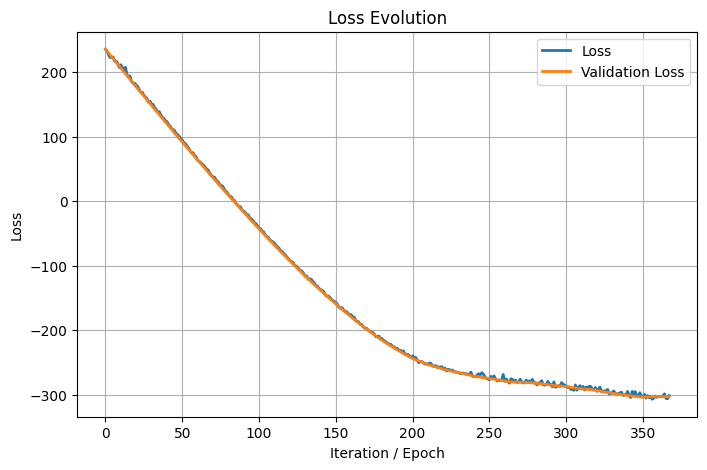

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.6008e+00,  1.1771e+00,  1.1630e+00,  1.2287e+00,  1.3168e+00,
         1.9664e+00,  1.2689e+00,  8.1689e-01,  1.6422e+00,  1.9873e+00,
         2.1136e+00,  2.2036e+00, -9.1856e+00,  1.0135e+00,  1.2890e+00,
         1.1442e+00,  1.0960e+00,  1.4920e+00,  1.1861e+00,  1.3470e+00,
         2.0092e+00,  2.3561e+00,  2.4629e+00,  2.1629e+00, -2.8188e-02,
        -6.3029e-04,  3.4317e-03,  2.4054e-02, -5.6883e-02,  5.0297e-02,
         1.0561e-02, -7.8740e-02, -4.6389e-02,  3.1860e-02,  2.9291e-01,
         3.1673e-01,  2.5529e-01,  2.1135e-01,  1.5478e-01,  2.6676e-01,
         2.1495e-02, -2.0789e-01, -1.0025e-01, -3.2743e-01, -3.4969e-01,
         6.7403e-01,  5.1114e-01,  3.4768e-01,  2.1489e-01,  1.6286e-01,
         2.0995e-01,  2.5227e-01, -1.4774e-02,  3.7954e-01,  4.5651e-01,
         3.4763e-01, -1.6154e-01,  5.7191e-02,  1.5318e-01, -8.8809e-02,
        -2.5284e-01,  1.0992e-01,  1.1306e-01,  7.5092e-02, -1.1024e-02,
         1.6113e-02, -1.4275e-02,  1.1926e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.2056
KLD Gaussian Train Data:  0.0911
KLD Copula   Train Data:  -0.0006
KLD GTM      Test  Data:  1.2143
KLD Gaussian Test  Data:  0.1112
KLD Copula   Test  Data:  0.0024


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

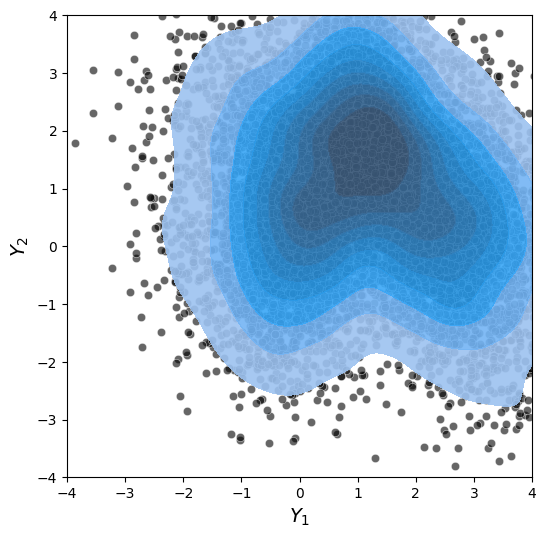

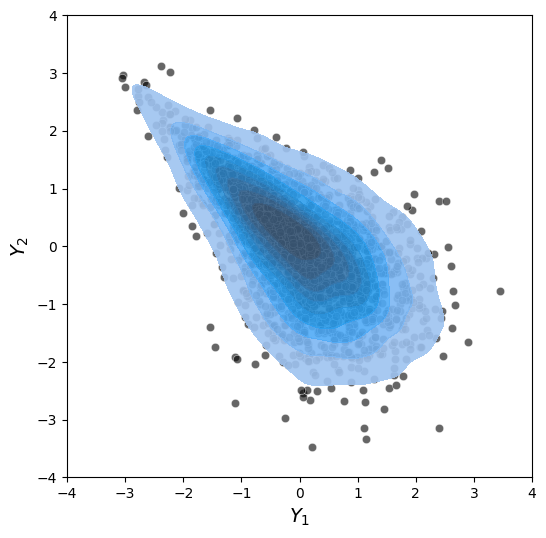

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


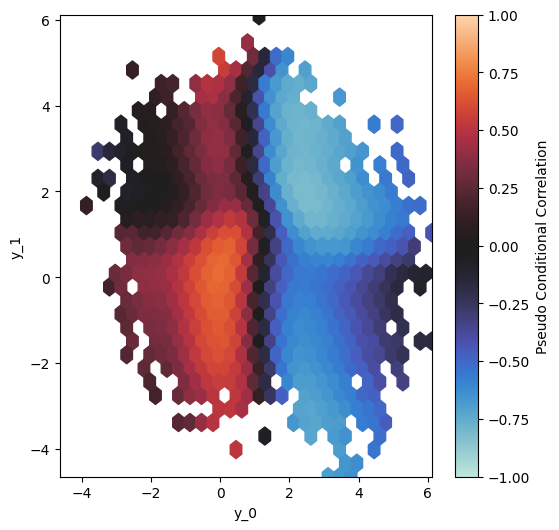

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


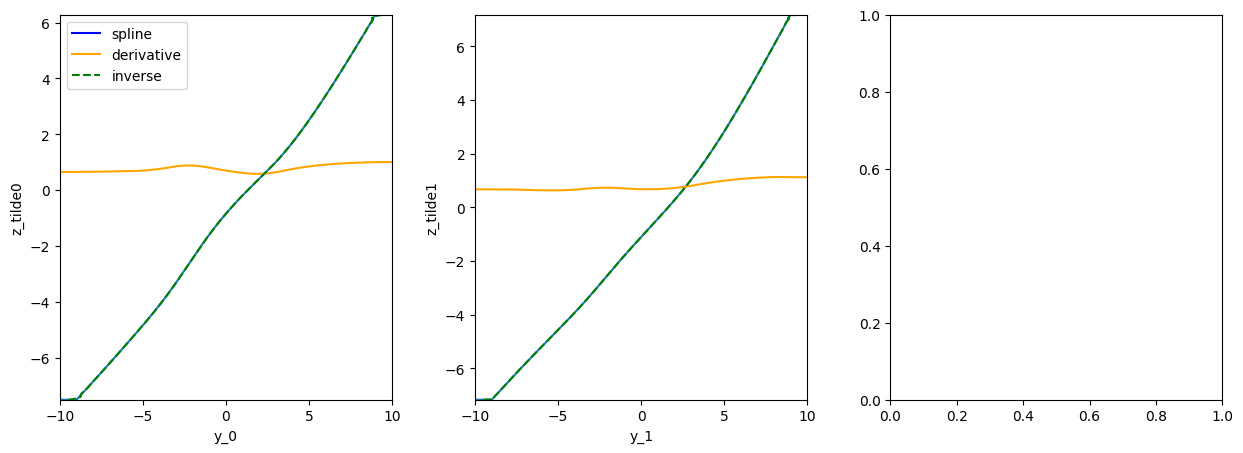

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


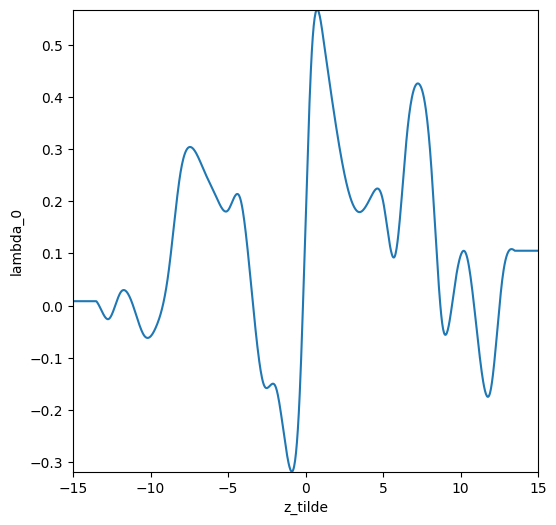

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


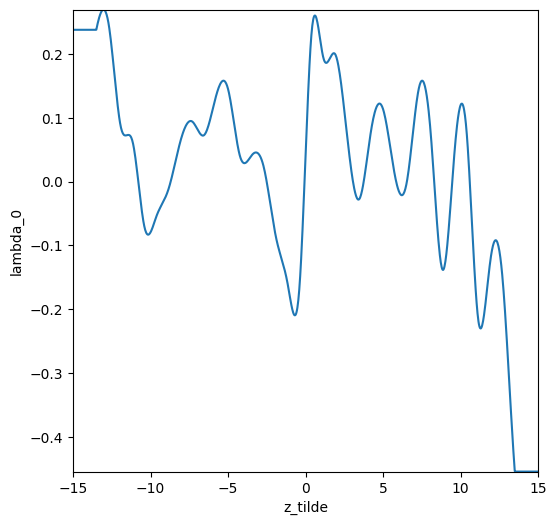

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


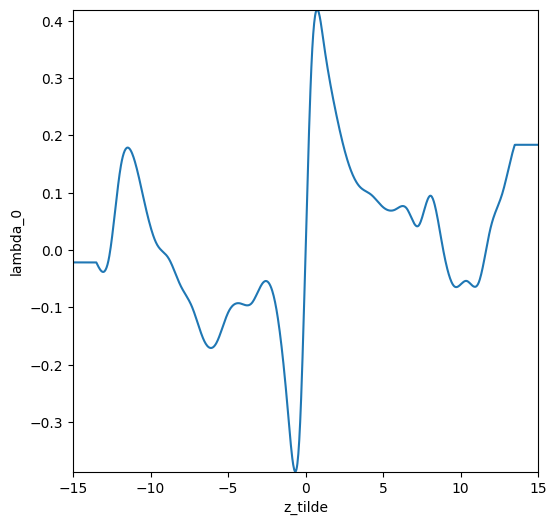

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)